In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [3]:
spark= SparkSession.builder.appName('linearr').getOrCreate()

In [4]:
airbnbDF = spark.read.parquet("part-00000-tid-4320459746949313749-5c3d407c-c844-4016-97ad-2edec446aa62-6688-1-c000.snappy.parquet")

In [5]:
airbnbDF.select("bedrooms","bathrooms", "price").show(10)

+--------+---------+-----+
|bedrooms|bathrooms|price|
+--------+---------+-----+
|     1.0|      1.0|170.0|
|     2.0|      1.0|235.0|
|     1.0|      4.0| 65.0|
|     1.0|      4.0| 65.0|
|     2.0|      1.5|785.0|
|     2.0|      1.0|255.0|
|     1.0|      1.0|139.0|
|     1.0|      1.0|135.0|
|     2.0|      1.0|265.0|
|     3.0|      1.0|177.0|
+--------+---------+-----+
only showing top 10 rows



In [6]:
trainDF, testDF = airbnbDF.randomSplit([.8, .2])

In [7]:
vecAssembler = VectorAssembler(inputCols=["bedrooms","bathrooms"], outputCol="features")
vecTrainDF = vecAssembler.transform(trainDF)

In [8]:
vecTrainDF.select("bedrooms","bathrooms","price","features").show(5)

+--------+---------+-----+---------+
|bedrooms|bathrooms|price| features|
+--------+---------+-----+---------+
|     1.0|      1.0|200.0|[1.0,1.0]|
|     1.0|      1.0| 85.0|[1.0,1.0]|
|     1.0|      1.0| 95.0|[1.0,1.0]|
|     3.0|      3.0|250.0|[3.0,3.0]|
|     1.0|      1.0| 45.0|[1.0,1.0]|
+--------+---------+-----+---------+
only showing top 5 rows



In [9]:
lr = LinearRegression(featuresCol="features", labelCol="price",maxIter=10, regParam=0.5,elasticNetParam=1)
lrModel = lr.fit(vecTrainDF)
print("model trained")

model trained


In [10]:
katsayı_1 =lrModel.coefficients[0]
katsayı_2=lrModel.coefficients[1]
b = lrModel.intercept
print("price=",katsayı_1,"*bedrooms","+",katsayı_2,"*bathrooms","+",b)

price= 115.85925566942744 *bedrooms + 23.32063050667552 *bathrooms + 28.032323564487733


In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

In [12]:
predDF = pipelineModel.transform(testDF)
predDF.select("bedrooms","bathrooms", "features", "price", "prediction").show(10)

+--------+---------+---------+-----+------------------+
|bedrooms|bathrooms| features|price|        prediction|
+--------+---------+---------+-----+------------------+
|     1.0|      1.0|[1.0,1.0]|130.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]|250.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]|115.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]| 70.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]|128.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]|250.0| 167.2122097405907|
|     1.0|      1.0|[1.0,1.0]|100.0| 167.2122097405907|
|     2.0|      3.0|[2.0,3.0]|199.0| 329.7127264233692|
|     1.0|      2.0|[1.0,2.0]| 71.0|190.53284024726622|
|     2.0|      2.0|[2.0,2.0]|250.0| 306.3920959166937|
+--------+---------+---------+-----+------------------+
only showing top 10 rows



testingDataFinal = assembler.transform(
    testingData).select(
    col("features"), (col("price")).cast("Int").alias("price"))
prediction = model.transform(testingDataFinal)

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predDF)
print ("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 307.42443972361843


In [14]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="price",metricName="r2")
r2=lr_evaluator.evaluate(predDF)
print("R Squared (R2) on test data = ",r2)

R Squared (R2) on test data =  0.08743209744175617


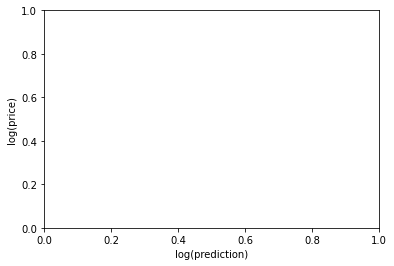

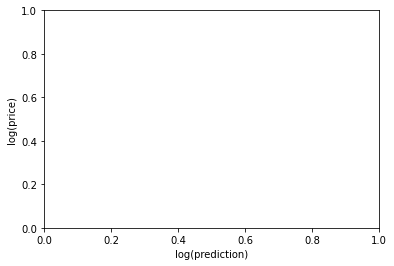

In [19]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.plot(xfit, yfit)

#Save
pipelineModel.write().overwrite().save("mllinear")

from pyspark.ml import PipelineModel
savedPipelineModel = PipelineModel.load("mllinear")